# Fake News Detection — Full Pipeline Notebook

**Contents**
1. Setup & imports  
2. Load `Fake.csv` & `True.csv` (you uploaded these)  
3. Inspect & merge, add labels  
4. Cleaning & preprocessing  
5. Exploratory Data Analysis (EDA)  
6. Train / Val / Test split  
7. Baseline: TF-IDF + Logistic Regression (train & evaluate)  
8. Stronger options: SBERT + XGBoost (example), BERT fine-tuning notes & code  
9. Explainability pointers (LIME/SHAP)  
10. Streamlit demo example  
11. Save models & reproducibility


In [5]:
# 1) Imports & settings
import os
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import shuffle

import joblib  # For saving models

print("Working directory:", os.getcwd())


Working directory: /content


In [6]:
# 2) Load uploaded CSVs (adjust paths if needed)
fake_path = "/content/drive/MyDrive/BIG DATA/Fake.csv"
true_path = "/content/drive/MyDrive/BIG DATA/True.csv"

fake = pd.read_csv(fake_path)
true = pd.read_csv(true_path)

print("Fake shape:", fake.shape)
print("True shape:", true.shape)
print("\nFake columns:", fake.columns.tolist())
print("True columns:", true.columns.tolist())


Fake shape: (23481, 4)
True shape: (21417, 4)

Fake columns: ['title', 'text', 'subject', 'date']
True columns: ['title', 'text', 'subject', 'date']


In [7]:
# 3) Merge & label
fake['label'] = 1
true['label'] = 0

def make_content(df):
    cols = df.columns.str.lower()
    title_col = None
    text_col = None
    for c in df.columns:
        if c.lower() == 'title':
            title_col = c
        if c.lower() in ('text', 'content', 'article'):
            text_col = c
    if title_col is None:
        possible = [c for c in df.columns if df[c].dtype == object]
        title_col = possible[0] if possible else None
    if text_col is None:
        possible = [c for c in df.columns if df[c].dtype == object and c != title_col]
        text_col = possible[0] if possible else None
    if title_col and text_col:
        df['content'] = df[title_col].fillna('') + '. ' + df[text_col].fillna('')
    elif title_col:
        df['content'] = df[title_col].fillna('')
    elif text_col:
        df['content'] = df[text_col].fillna('')
    else:
        df['content'] = df.astype(str).agg(' '.join, axis=1)
    return df

fake = make_content(fake)
true = make_content(true)

df = pd.concat([fake, true], ignore_index=True)
df = shuffle(df, random_state=42).reset_index(drop=True)

print("Merged shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())


Merged shape: (44898, 6)
Label distribution:
 label
1    23481
0    21417
Name: count, dtype: int64


In [8]:
import re
import os

def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s).lower()
    s = re.sub(r'(http\S+|www\.\S+)', ' ', s)
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

df['content_clean'] = df['content'].apply(clean_text)
df['content_len'] = df['content_clean'].apply(len)
df = df.drop_duplicates(subset=['content_clean']).reset_index(drop=True)
print("After dedup shape:", df.shape)

os.makedirs("/mnt/data", exist_ok=True)
df.to_csv("/mnt/data/all_news_clean.csv", index=False)
df.head(5)


After dedup shape: (38827, 8)


,title,text,subject,date,label,content,content_clean,content_len
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein calls out 9th circuit court committe...,1097
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0,Trump drops Steve Bannon from National Securit...,trump drops steve bannon from national securit...,4767
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u s to lift jones act ship...,1848
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump just accidentally confirmed he leak...,1268
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0,Donald Trump heads for Scotland to reopen a go...,donald trump heads for scotland to reopen a go...,3122


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38827 entries, 0 to 38826
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          38827 non-null  object
 1   text           38827 non-null  object
 2   subject        38827 non-null  object
 3   date           38827 non-null  object
 4   label          38827 non-null  int64 
 5   content        38827 non-null  object
 6   content_clean  38827 non-null  object
 7   content_len    38827 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 2.4+ MB
None

Missing values per column:
 title            0
text             0
subject          0
date             0
label            0
content          0
content_clean    0
content_len      0
dtype: int64

Label counts:
 label
0    20926
1    17901
Name: count, dtype: int64

Class ratio:
 label
0    0.538955
1    0.461045
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,20926.0,2383.810188,1640.285403,29.0,958.0,2229.0,3207.75,29181.0
1,17901.0,2512.840959,2157.362092,0.0,1626.0,2238.0,2994.00,50826.0


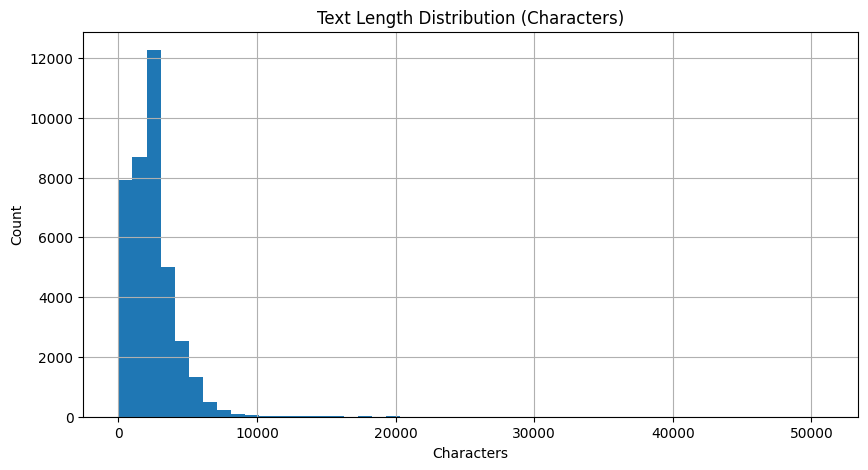

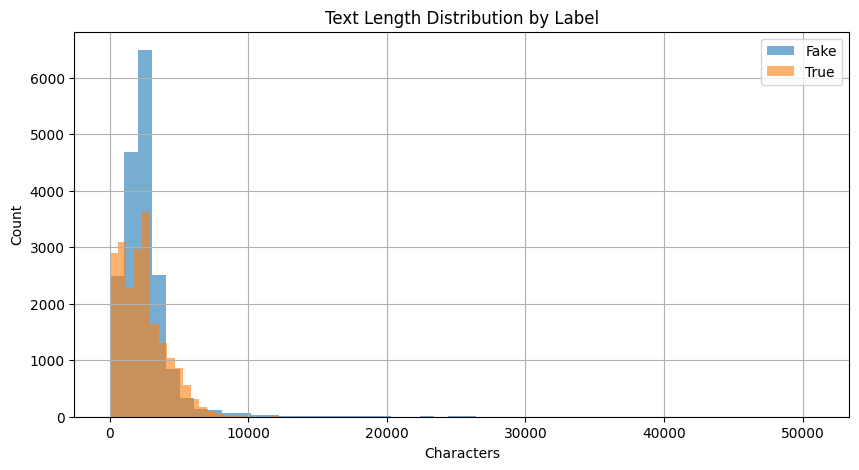


=== Sample Fake ===


,content_clean
0,ben stein calls out 9th circuit court committe...
3,oops trump just accidentally confirmed he leak...
5,paul ryan responds to dem s sit in on gun cont...



=== Sample True ===


,content_clean
1,trump drops steve bannon from national securit...
2,puerto rico expects u s to lift jones act ship...
4,donald trump heads for scotland to reopen a go...


In [10]:
import matplotlib.pyplot as plt

print(df.info())
print("\nMissing values per column:\n", df.isna().sum())
print("\nLabel counts:\n", df['label'].value_counts())
print("\nClass ratio:\n", df['label'].value_counts(normalize=True))

# Text length stats
display(df.groupby('label')['content_len'].describe())

# Plot text length histogram
plt.figure(figsize=(10, 5))
df['content_len'].hist(bins=50)
plt.title("Text Length Distribution (Characters)")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

# Label-specific histogram
plt.figure(figsize=(10, 5))
df[df['label']==1]['content_len'].hist(bins=50, alpha=0.6, label='Fake')
df[df['label']==0]['content_len'].hist(bins=50, alpha=0.6, label='True')
plt.title("Text Length Distribution by Label")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.legend()
plt.show()

# Show top 3 samples from each class
print("\n=== Sample Fake ===")
display(df[df['label']==1].head(3)[['content_clean']])
print("\n=== Sample True ===")
display(df[df['label']==0].head(3)[['content_clean']])


In [11]:
# 6) Train / Val / Test split (stratified)
from sklearn.model_selection import train_test_split
import os

# Features and labels
X = df['content_clean']
y = df['label']

# 70% train, 30% temp
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 15% val, 15% test from the 30%
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

# Create DataFrames
train_df = pd.DataFrame({'content': X_train, 'label': y_train}).reset_index(drop=True)
val_df   = pd.DataFrame({'content': X_val, 'label': y_val}).reset_index(drop=True)
test_df  = pd.DataFrame({'content': X_test, 'label': y_test}).reset_index(drop=True)

# Print shapes
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Check label distribution
print("\nLabel distribution:")
print("Train:\n", train_df['label'].value_counts(normalize=True))
print("Val:\n", val_df['label'].value_counts(normalize=True))
print("Test:\n", test_df['label'].value_counts(normalize=True))

# Save splits
os.makedirs("/mnt/data", exist_ok=True)
train_df.to_csv("/mnt/data/train.csv", index=False)
val_df.to_csv("/mnt/data/val.csv", index=False)
test_df.to_csv("/mnt/data/test.csv", index=False)


Train shape: (27178, 2)
Val shape: (5824, 2)
Test shape: (5825, 2)

Label distribution:
Train:
 label
0    0.538965
1    0.461035
Name: proportion, dtype: float64
Val:
 label
0    0.538977
1    0.461023
Name: proportion, dtype: float64
Test:
 label
0    0.538884
1    0.461116
Name: proportion, dtype: float64


In [12]:
# 7) Baseline: TF-IDF + LogisticRegression
import os

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga'))
])

# Train
pipeline.fit(train_df['content'], train_df['label'])

# Predict on test
pred = pipeline.predict(test_df['content'])
probs = pipeline.predict_proba(test_df['content'])[:,1]

# Evaluate
print("Classification report (test):")
print(classification_report(test_df['label'], pred))
print("\nConfusion matrix:")
print(confusion_matrix(test_df['label'], pred))
print("\nROC AUC:", roc_auc_score(test_df['label'], probs))

# Save model
os.makedirs("/mnt/data", exist_ok=True)
joblib.dump(pipeline, "/mnt/data/tfidf_logreg_baseline.joblib")
print("Saved baseline model to /mnt/data/tfidf_logreg_baseline.joblib")


Classification report (test):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3139
           1       0.99      0.98      0.99      2686

    accuracy                           0.99      5825
   macro avg       0.99      0.99      0.99      5825
weighted avg       0.99      0.99      0.99      5825


Confusion matrix:
[[3115   24]
 [  55 2631]]

ROC AUC: 0.9988213043836138
Saved baseline model to /mnt/data/tfidf_logreg_baseline.joblib


In [13]:
# 8) SBERT sentence embeddings + XGBoost (example - requires 'sentence_transformers' and 'xgboost')
'''
from sentence_transformers import SentenceTransformer
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Load SBERT model
sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Encode text
train_emb = sbert.encode(train_df['content'].tolist(), show_progress_bar=True)
test_emb  = sbert.encode(test_df['content'].tolist(), show_progress_bar=True)

# Normalize embeddings
scaler = StandardScaler()
train_emb = scaler.fit_transform(train_emb)
test_emb = scaler.transform(test_emb)

# Train XGBoost
clf = xgb.XGBClassifier(n_estimators=300, max_depth=6, use_label_encoder=False, eval_metric='logloss')
clf.fit(train_emb, train_df['label'])

# Predict and evaluate
pred = clf.predict(test_emb)
probs = clf.predict_proba(test_emb)[:, 1]

print(classification_report(test_df['label'], pred))
print("ROC AUC:", roc_auc_score(test_df['label'], probs))

# Save model
os.makedirs("/mnt/data", exist_ok=True)
joblib.dump(clf, '/mnt/data/xgb_sbert.joblib')
'''
print("SBERT+XGBoost example cell: run this in an environment with 'sentence_transformers' and 'xgboost' installed.")


SBERT+XGBoost example cell: run this in an environment with 'sentence_transformers' and 'xgboost' installed.


In [14]:
# 9) BERT / RoBERTa fine-tuning template (Hugging Face) - requires GPU
'''
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import os

# Convert to Hugging Face datasets
train_ds = Dataset.from_pandas(train_df[['content','label']])
val_ds   = Dataset.from_pandas(val_df[['content','label']])
test_ds  = Dataset.from_pandas(test_df[['content','label']])

# Load tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize
def preprocess(batch):
    return tokenizer(batch['content'], truncation=True, padding='max_length', max_length=256, return_token_type_ids=False)

train_ds = train_ds.map(preprocess, batched=True)
val_ds = val_ds.map(preprocess, batched=True)
test_ds = test_ds.map(preprocess, batched=True)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Metrics
f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "f1": f1.compute(predictions=preds, references=labels, average='binary')["f1"],
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"]
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="hf_roberta_finetune",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

# Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train and evaluate
trainer.train()
trainer.evaluate()
trainer.evaluate(test_ds)

# Save model
os.makedirs("/mnt/data", exist_ok=True)
trainer.save_model("/mnt/data/roberta_finetuned_model")
'''
print("BERT fine-tuning template cell: run on a machine with GPU and the necessary libraries installed.")


BERT fine-tuning template cell: run on a machine with GPU and the necessary libraries installed.


In [15]:
# 10) Explainability pointers
# Example: LIME for text with the baseline pipeline
'''
from lime.lime_text import LimeTextExplainer
import random

# Initialize explainer
explainer = LimeTextExplainer(class_names=['real','fake'])

# Pick a random test sample
i = random.randint(0, len(test_df)-1)
print("Explaining prediction for sample:", test_df['content'].iloc[i])

# Generate explanation
exp = explainer.explain_instance(
    test_df['content'].iloc[i],
    pipeline.predict_proba,
    num_features=10
)

# Show explanation
exp.show_in_notebook(text=True)
'''
print("Use LIME/SHAP to explain predictions. Example code (commented) shows how to run LIME on the TF-IDF pipeline.")


Use LIME/SHAP to explain predictions. Example code (commented) shows how to run LIME on the TF-IDF pipeline.


In [16]:
# 11) Streamlit demo example (save as app.py and run `streamlit run app.py`)
'''
import streamlit as st
import joblib

# Load model
model = joblib.load('/mnt/data/tfidf_logreg_baseline.joblib')

# UI
st.title('📰 Fake News Detector - Demo')
txt = st.text_area('Paste article or headline here')

if st.button('Predict'):
    if txt.strip() == "":
        st.warning("Please enter some text before predicting.")
    else:
        pred = model.predict([txt])[0]
        prob = model.predict_proba([txt])[0][1]
        label = 'Fake' if pred==1 else 'Real'
        st.write(f"Prediction: **{label}** (fake probability = {prob:.3f})")
        st.progress(prob)
'''
print("Streamlit demo example cell: save the commented block to app.py and run with Streamlit.")


Streamlit demo example cell: save the commented block to app.py and run with Streamlit.


In [17]:
# 12) Reproducibility notes & requirements.txt suggestion
reqs = '''
pandas
numpy
scikit-learn
joblib
matplotlib
# Optional for stronger models:
sentence-transformers
xgboost
transformers
datasets
evaluate
accelerate
lime
shap
streamlit
'''

print("Suggested requirements (save to requirements.txt):\n", reqs)

import os
os.makedirs("/mnt/data", exist_ok=True)
with open('/mnt/data/requirements_suggested.txt','w') as f:
    f.write(reqs)

print("Saved suggested requirements to /mnt/data/requirements_suggested.txt")


Suggested requirements (save to requirements.txt):
 
pandas
numpy
scikit-learn
joblib
matplotlib
# Optional for stronger models:
sentence-transformers
xgboost
transformers
datasets
evaluate
accelerate
lime
shap
streamlit

Saved suggested requirements to /mnt/data/requirements_suggested.txt
